In [11]:
import pickle
from torch import linalg as LA
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
NUM_OF_MODELS = 500

In [16]:
with open('real_matrix_list.pickle', 'rb') as f:
    real_matrices= pickle.load(f)
with open('scrambled_matrix_list.pickle', 'rb') as f:
    scrambled_matrices= pickle.load(f)
with open('generated_matrix_list.pickle', 'rb') as f:
    generated_matrices= pickle.load(f)

In [36]:
real_state_dicts = []
for matrix in real_matrices:
    W = matrix[:, :-1] 
    b = matrix[:, -1] 
    state_dict = {"linear.weight": W, "linear.bias": b}
    real_state_dicts.append(state_dict)
scrambled_state_dicts = []
for matrix in scrambled_matrices:
    W = matrix[:, :-1] 
    b = matrix[:, -1]  
    state_dict = {"linear.weight": W, "linear.bias": b}
    scrambled_state_dicts.append(state_dict)
generated_state_dicts = []
for matrix in generated_matrices:
    W = matrix[:, :-1]  
    b = matrix[:, -1] 
    state_dict = {"linear.weight": W, "linear.bias": b}
    generated_state_dicts.append(state_dict)

In [32]:
real_plot = real_matrices[0:-1:20]
scrambled_plot = scrambled_matrices[0:-1:20]
generated_plot = generated_matrices[0:-1:20]
num_of_objects = len(real_plot)

In [26]:
def metric(A, B):
    return LA.matrix_norm((A - B), ord=2).item()

distances_real_real = []
distances_scrambled_scrambled = []
for i in range(num_of_objects):
    for j in range(i + 1, num_of_objects):
        d_r_r = metric(real_plot[i], real_plot[j])
        d_s_s = metric(scrambled_plot[i], scrambled_plot[j])
        distances_real_real.append(d_r_r)
        distances_scrambled_scrambled.append(d_s_s)

distances_real_scrambled = []
for r in real_plot:
    for s in scrambled_plot:
        d_r_s = metric(r, s)
        distances_real_scrambled.append(d_r_s)

In [28]:
def reshape_to_matrix(distances_list):
    matrix = np.zeros((num_of_objects, num_of_objects))
    index = 0
    for i in range(num_of_objects):
        for j in range(i + 1, num_of_objects):
            matrix[i][j] = distances_list[index]
            matrix[j][i] = distances_list[index]
            index += 1
    return matrix

real_real_matrix = reshape_to_matrix(distances_real_real)
real_scrambled_matrix = np.reshape(
    distances_real_scrambled, (num_of_objects, num_of_objects)
)
scrambled_scrambled_matrix = reshape_to_matrix(distances_scrambled_scrambled)


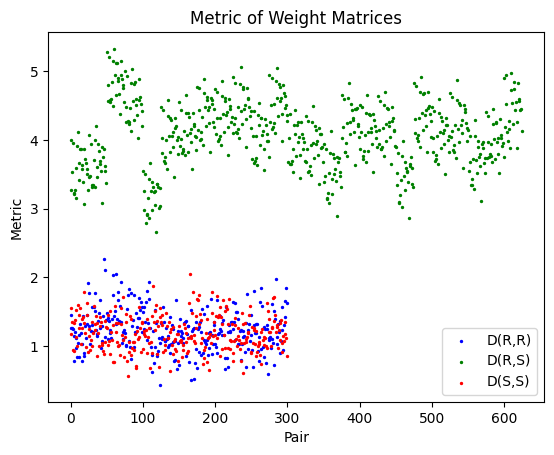

In [29]:
plt.scatter(
    range(len(distances_real_real)),
    distances_real_real,
    color="blue",
    label="D(R,R)",
    s=2,
)
plt.scatter(
    range(len(distances_real_scrambled)),
    distances_real_scrambled,
    color="green",
    label="D(R,S)",
    s=2,
)
plt.scatter(
    range(len(distances_scrambled_scrambled)),
    distances_scrambled_scrambled,
    color="red",
    label="D(S,S)",
    s=2,
)
plt.xlabel("Pair")
plt.ylabel("Metric")
plt.legend()
plt.title("Metric of Weight Matrices")
plt.show()

In [33]:
upper_left_block = real_real_matrix
upper_right_block = real_scrambled_matrix
lower_left_block = real_scrambled_matrix.T
lower_right_block = scrambled_scrambled_matrix

distances_matrix = np.block(
    [[upper_left_block, upper_right_block], [lower_left_block, lower_right_block]]
)

perplexity = min(15, 2 * num_of_objects - 1)
tsne = TSNE(n_components=2, perplexity=perplexity)
embedded_distances_matrix = tsne.fit_transform(distances_matrix)
embedded_real = embedded_distances_matrix[:num_of_objects]
embedded_scrambled = embedded_distances_matrix[num_of_objects:]

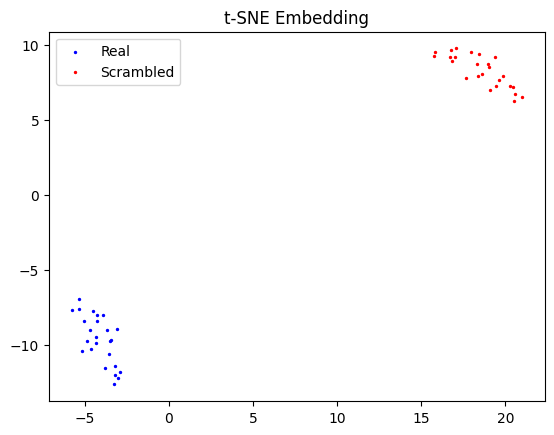

In [34]:
plt.scatter(embedded_real[:, 0], embedded_real[:, 1], color="blue", label="Real", s=2)
plt.scatter(
    embedded_scrambled[:, 0],
    embedded_scrambled[:, 1],
    color="red",
    label="Scrambled",
    s=2,
)
plt.title("t-SNE Embedding")
plt.legend()
plt.title("t-SNE Embedding")
plt.show()

In [ ]:
diagonal_real = []
diagonal_scrambled = []

for model_info in real_models:
    model = IrisClassifier().to(device=device)
    model.load_state_dict(model_info.state_dict)
    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test)
        _, predicted_labels = torch.max(y_pred, 1)
    cm = confusion_matrix(y_test.cpu().numpy(), predicted_labels.cpu().numpy())
    diagonal = np.sum(np.diag(cm))
    diagonal_real.append(diagonal / len(y_test))

for model_info in scrambled_models:
    model = IrisClassifier().to(device=device)
    model.load_state_dict(model_info.state_dict)
    model.eval()
    with torch.inference_mode():
        y_pred = model(X_test)
        _, predicted_labels = torch.max(y_pred, 1)
    cm = confusion_matrix(y_test.cpu().numpy(), predicted_labels.cpu().numpy())
    diagonal = np.sum(np.diag(cm))
    diagonal_scrambled.append(diagonal / len(y_test))

print("Diag(R): {:.4f}".format(np.mean(diagonal_real)))
print("Diag(S): {:.4f}".format(np.mean(diagonal_scrambled)))